CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation.  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'cnn',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 50,
    "batch_size": 64,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.008,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 0 1 0 1 1]
[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 0 1 1 1 1 0]
[0 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [5]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config['img_shape']))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(1, activation='sigmoid'))
# cnn_model.add(layers.Dense(params['num_classes'], activation='softmax'))

In [6]:
if config['verbosity'] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [7]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [8]:
def make_model():
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    cnn_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return cnn_model

In [9]:
log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')
earlystopping_cb = EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)

callbacks = [tensorboard_cb, earlystopping_cb]

## Baseline

In [10]:
baseline_model = make_model()

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/50
546/546 [==============================] - 12s 23ms/step - loss: 0.2371 - tp: 30705.0000 - fp: 2370.0000 - tn: 1111.0000 - fn: 758.0000 - accuracy: 0.9105 - precision: 0.9283 - recall: 0.9759 - auc: 0.8834 - val_loss: 0.1812 - val_tp: 6582.0000 - val_fp: 306.0000 - val_tn: 409.0000 - val_fn: 191.0000 - val_accuracy: 0.9336 - val_precision: 0.9556 - val_recall: 0.9718 - val_auc: 0.9371
Epoch 2/50
546/546 [==============================] - 5s 9ms/step - loss: 0.1694 - tp: 30783.0000 - fp: 1588.0000 - tn: 1892.0000 - fn: 681.0000 - accuracy: 0.9351 - precision: 0.9509 - recall: 0.9784 - auc: 0.9369 - val_loss: 0.1729 - val_tp: 6742.0000 - val_fp: 512.0000 - val_tn: 203.0000 - val_fn: 31.0000 - val_accuracy: 0.9275 - val_precision: 0.9294 - val_recall: 0.9954 - val_auc: 0.9373
Epoch 3/50
546/546 [==============================] - 5s 9ms/step - loss: 0.1459 - tp: 30897.0000 - fp: 1367.0000 - tn: 2112.0000 - fn: 568.0000 - accuracy: 0.94

`Keras`
Save/load the model

In [11]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

#### Validate the results

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Some functions

In [13]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [14]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    print()

In [15]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [16]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

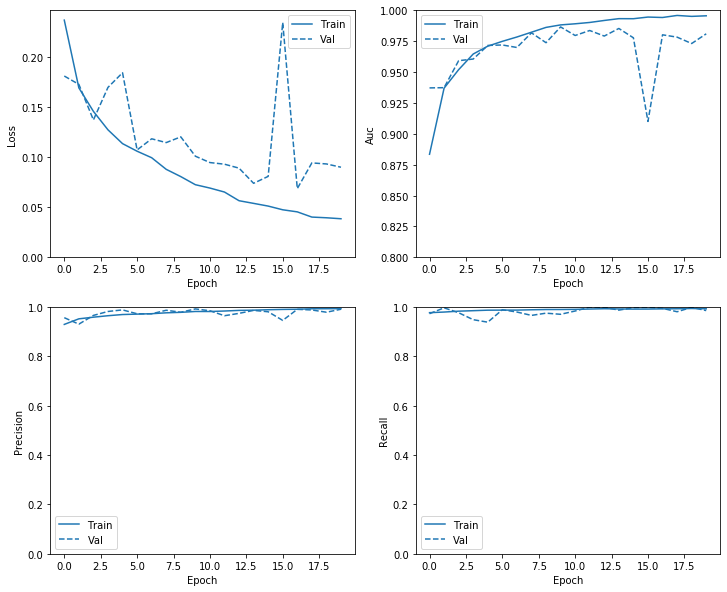

In [17]:
plot_metrics(baseline_history)

In [18]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=4000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=4000)

117/117 - 4s - loss: 0.1126 - tp: 6513.0000 - fp: 68.0000 - tn: 688.0000 - fn: 219.0000 - accuracy: 0.9617 - precision: 0.9897 - recall: 0.9675 - auc: 0.9837

loss : 0.11261124047649722
tp : 6513.0
fp : 68.0
tn : 688.0
fn : 219.0
accuracy : 0.9616720080375671
precision : 0.9896672368049622
recall : 0.967468798160553
auc : 0.9836697578430176

Legitimate Transactions Detected (True Negatives):  337
Legitimate Transactions Incorrectly Detected (False Positives):  29
Fraudulent Transactions Missed (False Negatives):  114
Fraudulent Transactions Detected (True Positives):  3520
Total Fraudulent Transactions:  3634



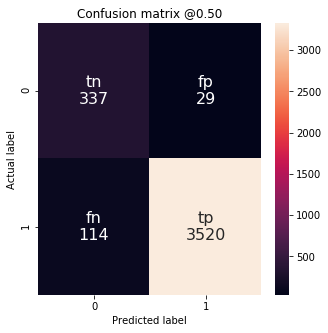

In [19]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

plot_cm(train_labels_baseline, train_predictions_baseline)

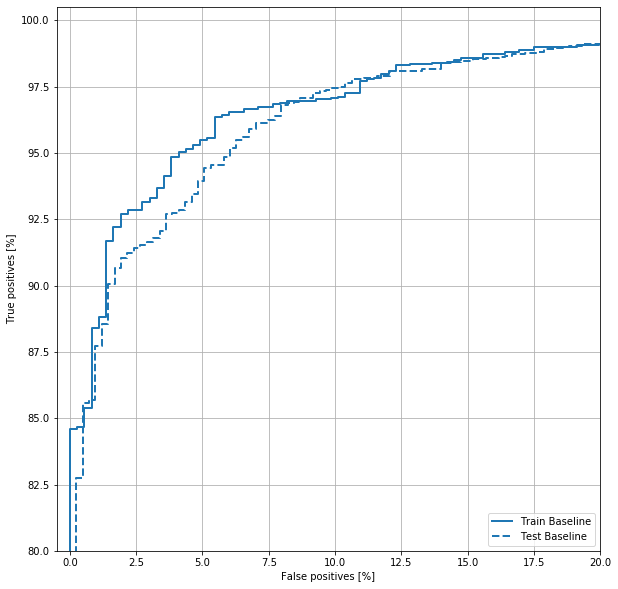

In [20]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [21]:
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.00
Weight for class 1: 0.56


In [22]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/50
546/546 [==============================] - 7s 13ms/step - loss: 0.0694 - tp: 31122.0000 - fp: 594.0000 - tn: 2884.0000 - fn: 344.0000 - accuracy: 0.9732 - precision: 0.9813 - recall: 0.9891 - auc: 0.9882 - val_loss: 0.1145 - val_tp: 6583.0000 - val_fp: 95.0000 - val_tn: 620.0000 - val_fn: 190.0000 - val_accuracy: 0.9619 - val_precision: 0.9858 - val_recall: 0.9719 - val_auc: 0.9781
Epoch 2/50
546/546 [==============================] - 5s 9ms/step - loss: 0.0620 - tp: 31171.0000 - fp: 508.0000 - tn: 2976.0000 - fn: 289.0000 - accuracy: 0.9772 - precision: 0.9840 - recall: 0.9908 - auc: 0.9904 - val_loss: 0.1105 - val_tp: 6739.0000 - val_fp: 221.0000 - val_tn: 494.0000 - val_fn: 34.0000 - val_accuracy: 0.9659 - val_precision: 0.9682 - val_recall: 0.9950 - val_auc: 0.9704
Epoch 3/50
546/546 [==============================] - 5s 8ms/step - loss: 0.0565 - tp: 31152.0000 - fp: 409.0000 - tn: 3068.0000 - fn: 315.0000 - accuracy: 0.9793 - 

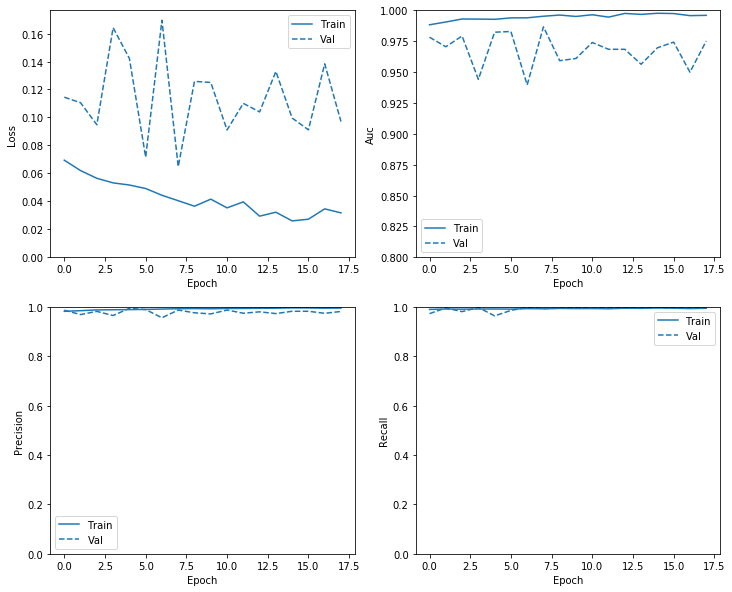

In [23]:
plot_metrics(weighted_history)

In [24]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=4000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=400)

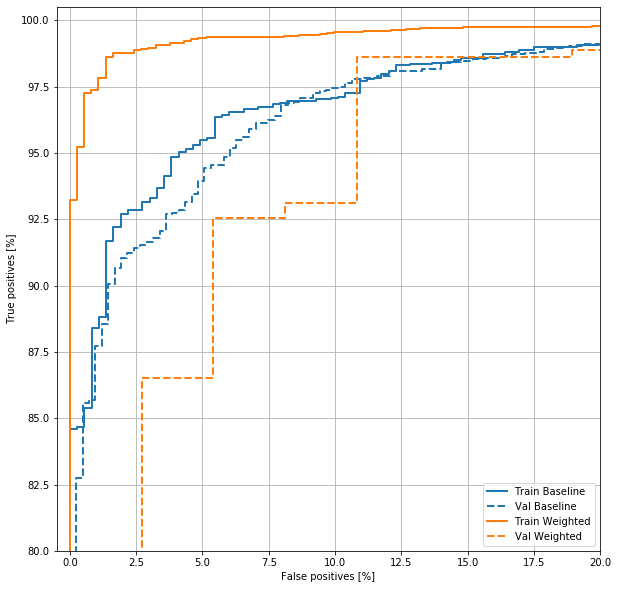

In [25]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

## Oversampling the minority class

In [26]:
# Remove the cache
!rm -rf ./cache/*

config["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [27]:
train_ds_resampled, test_ds_resampled, val_ds_resampled, params = create_dataset(config)

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1]
[0 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 1 1 0 1 1 1 1 1 1]
[1 0 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]

Resamplng the dataset..

Fractions:  [0.09902344 0.90097654]
Counts:  [1014. 9226.]

[0 0 1 0 0 1 0 0 0 0]
[0 1 1 0 0 1 1 0 0 0]
[0 1 1 0 0 1 1 0 0 0]
[0 1 1 0 1 0 0 0 0 1]
[0 0 1 0 0 0 0 0 1 0]
[1 1 1 1 0 0 1 1 1 0]
[0 1 1 1 1 0 1 0 0 0]
[0 0 1 0 0 1 0 1 0 1]
[1 1 0 0 0 0 1 0 1 0]
[0 1 1 1 0 1 1 0 1 0]


In [28]:
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.375
0.578125
0.5625


In [29]:
resampled_steps_per_epoch = np.ceil(2.0*neg/config["batch_size"])
print (resampled_steps_per_epoch)

157.0


In [30]:
resampled_model = make_model()

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = resampled_steps_per_epoch,
    epochs = config["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = resampled_steps_per_epoch,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 157.0 steps, validate for 157.0 steps
Epoch 1/50
157/157 [==============================] - 25s 162ms/step - loss: 0.1545 - tp: 4736.0000 - fp: 223.0000 - tn: 4824.0000 - fn: 265.0000 - accuracy: 0.9514 - precision: 0.9550 - recall: 0.9470 - auc: 0.9868 - val_loss: 0.1184 - val_tp: 4949.0000 - val_fp: 279.0000 - val_tn: 4697.0000 - val_fn: 123.0000 - val_accuracy: 0.9600 - val_precision: 0.9466 - val_recall: 0.9757 - val_auc: 0.9918
Epoch 2/50
157/157 [==============================] - 5s 34ms/step - loss: 0.1028 - tp: 4852.0000 - fp: 164.0000 - tn: 4841.0000 - fn: 191.0000 - accuracy: 0.9647 - precision: 0.9673 - recall: 0.9621 - auc: 0.9929 - val_loss: 0.0974 - val_tp: 4962.0000 - val_fp: 230.0000 - val_tn: 4755.0000 - val_fn: 101.0000 - val_accuracy: 0.9671 - val_precision: 0.9557 - val_recall: 0.9801 - val_auc: 0.9946
Epoch 3/50
157/157 [==============================] - 6s 36ms/step - loss: 0.0836 - tp: 4940.0000 - fp: 132.0000 - tn: 4822.0000 - fn: 154.0000 - accuracy: 

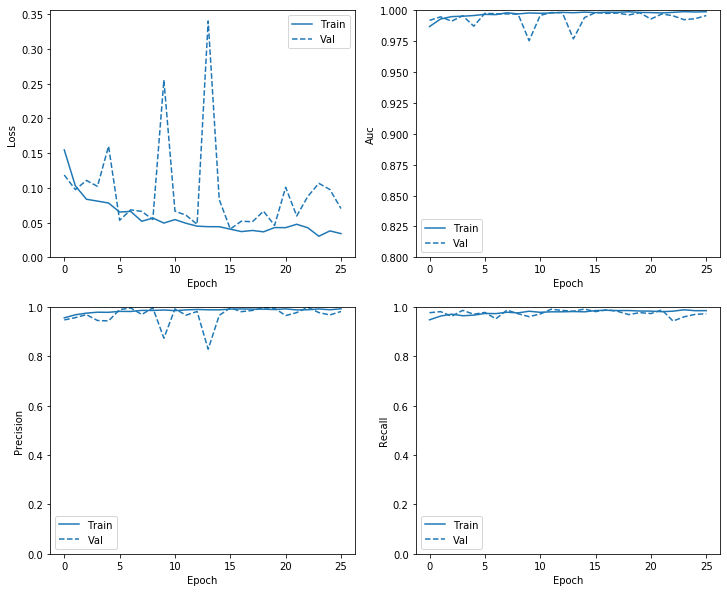

In [31]:
plot_metrics(resampled_history)

In [32]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=4000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds, resampled_model, samples=400)

117/117 - 20s - loss: 0.0549 - tp: 3600.0000 - fp: 20.0000 - tn: 3774.0000 - fn: 94.0000 - accuracy: 0.9848 - precision: 0.9945 - recall: 0.9746 - auc: 0.9967

loss : 0.0548829211272363
tp : 3600.0
fp : 20.0
tn : 3774.0
fn : 94.0
accuracy : 0.9847756624221802
precision : 0.9944751262664795
recall : 0.9745533466339111
auc : 0.9967222213745117

Legitimate Transactions Detected (True Negatives):  1975
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  26
Fraudulent Transactions Detected (True Positives):  1992
Total Fraudulent Transactions:  2018



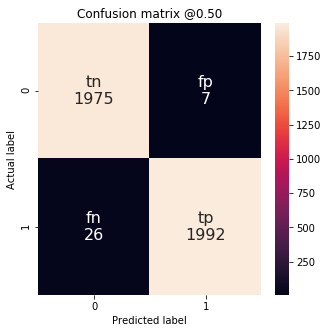

In [33]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/resampled_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

plot_cm(train_labels_resampled, train_predictions_resampled)

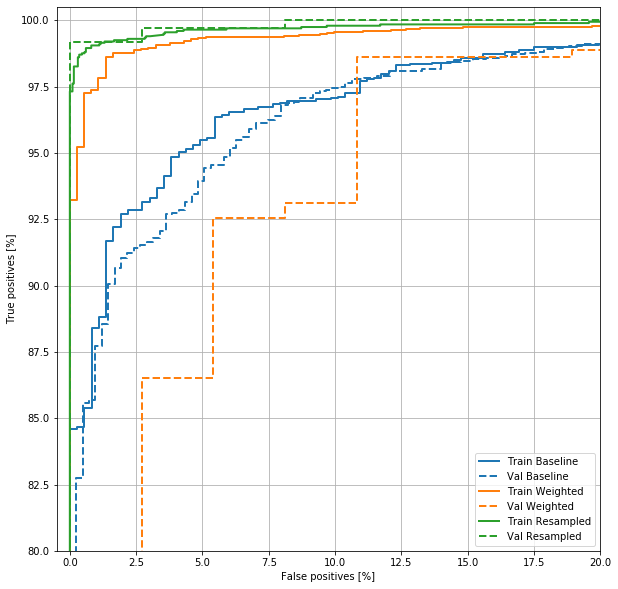

In [34]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');

`Tensorboard`

## Predict new samples

In [35]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 | 0.0
Image 43 of 64


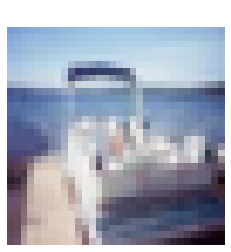

In [36]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resampled_model.predict(np.expand_dims(image, axis=0))[0]
pred = predictions[0]
print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [37]:
# Predict one batch
predictions = resampled_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  1.000  1.000
  2  1.000  1.000
  3  1.000  1.000
  4  1.000  1.000
  5  1.000  1.000
  6  1.000  1.000
  7  1.000  0.920
  8  1.000  1.000
  9  1.000  1.000
 10  1.000  1.000
 11  1.000  1.000
 12  0.000  0.001
 13  1.000  1.000
 14  0.000  0.025
 15  1.000  1.000
 16  1.000  1.000
 17  1.000  1.000
 18  1.000  0.653
 19  1.000  1.000
 20  1.000  1.000
 21  0.000  0.009
 22  1.000  1.000
 23  1.000  1.000
 24  1.000  1.000
 25  1.000  1.000
 26  1.000  1.000
 27  1.000  0.999
 28  1.000  1.000
 29  1.000  1.000
 30  1.000  1.000
 31  1.000  1.000
 32  1.000  1.000
 33  1.000  1.000
 34  1.000  1.000
 35  1.000  1.000
 36  1.000  1.000
 37  1.000  1.000
 38  1.000  1.000
 39  1.000  1.000
 40  1.000  1.000
 41  1.000  1.000
 42  1.000  1.000
 43  0.000  0.000
 44  1.000  1.000
 45  1.000  1.000
 46  1.000  1.000
 47  1.000  1.000
 48  1.000  1.000
 49  1.000  1.000
 50  1.000  1.000
 51  1.000  1.000
 52  1.000  1.000
 53  1.000 